# About

These is a base solution of PID.

In [38]:
%matplotlib inline
import random
import pandas
import numpy
import cPickle as pickle
import matplotlib.pyplot as plt

import root_numpy
from sklearn.metrics import roc_auc_score, roc_curve

from rep.estimators import TMVAClassifier, XGBoostClassifier

# Directories

In [39]:
data_path = "data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/\
GhostAccFrac1.0/TMVA-Run2-NoTkLikCD/Long"

particle = 'Electron'
work_path = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/multiclass/Long/XGBoost/verbose=0;missing=-999.0;scale_pos_weight=1.0;random_state=0;num_feature=None;base_score=0.5;n_estimators=1000;subsample=0.5;eta=0.01;min_child_weight=1.0;colsample=0.7;max_depth=8;gamma=None;nthreads=3;"
netconfig_path = "data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
+ particle + "_Long_ANN.txt"

# Features

In [40]:
particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]
labs = [0, 1, 2, 3, 4, 5]

def get_features(netconfig_path):
    
    netconfig = numpy.loadtxt(netconfig_path, dtype='S', delimiter='\n', comments='!')
    features = []
    spectator_features = []

    for var in netconfig[5:]:

        if var.find('#') == -1:
            features.append(var)
        else:
            spectator_features.append(var[1:])
            
    return features

In [41]:
features_all = []

for one_particle in particles:
    
    netconfig_path = "data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
    + one_particle + "_Long_ANN.txt"

    features_all += get_features(netconfig_path)

In [42]:
features = numpy.unique(features_all)
features

array(['BremPIDe', 'CaloPrsE', 'EcalPIDe', 'EcalPIDmu', 'HcalPIDe',
       'HcalPIDmu', 'InAccBrem', 'InAccEcal', 'InAccHcal', 'InAccMuon',
       'InAccPrs', 'MuonBkgLL', 'MuonIsLooseMuon', 'MuonIsMuon',
       'MuonMuLL', 'MuonNShared', 'PrsPIDe', 'RichAboveKaThres',
       'RichAboveMuThres', 'RichAbovePiThres', 'RichAbovePrThres',
       'RichDLLbt', 'RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp',
       'RichUsedR1Gas', 'RichUsedR2Gas', 'TrackChi2PerDof',
       'TrackFitMatchChi2', 'TrackFitTChi2', 'TrackFitTNDoF',
       'TrackFitVeloChi2', 'TrackFitVeloNDoF', 'TrackGhostProbability',
       'TrackNumDof', 'TrackP', 'TrackPt'], 
      dtype='|S21')

# Classifiers

In [4]:
# Read classifier
clf_pickle2 = open(work_path + '/classifier.pkl', 'rb')
clf2 = pickle.load(clf_pickle2)
clf_pickle2.close()

# Read eval data

In [43]:
filename = data_path + "/data_eval.csv"

data_eval = pandas.read_csv(filename)

# Labels

In [44]:
particle_pdg_codes = {"all": 999999,
                    "Ghost": 0,
                    "Electron": 11,
                    "Muon": 13,
                    "Pion": 211,
                    "Kaon": 321,
                    "Proton": 2212}


pdg = particle_pdg_codes['Electron']
labels_electron = (numpy.abs(data_eval.MCParticleType.values) == pdg) * 1.

pdg = particle_pdg_codes['Proton']
labels_proton = (numpy.abs(data_eval.MCParticleType.values) == pdg) * 1.

pdg = particle_pdg_codes['Pion']
labels_pion = (numpy.abs(data_eval.MCParticleType.values) == pdg) * 1.

pdg = particle_pdg_codes['Muon']
labels_muon = (numpy.abs(data_eval.MCParticleType.values) == pdg) * 1.

pdg = particle_pdg_codes['Kaon']
labels_kaon = (numpy.abs(data_eval.MCParticleType.values) == pdg) * 1.

pdg = particle_pdg_codes['Ghost']
labels_ghost = (numpy.abs(data_eval.MCParticleType.values) == pdg) * 1.

# Probabilities

In [45]:
#proba_eval = clf2.predict_proba(data_eval)
proba_eval = numpy.loadtxt('xgboost_proba_eval.csv')

In [46]:
#particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]
#labs = [0, 1, 2, 3, 4, 5]

proba_electron = numpy.concatenate((1.-proba_eval[:, 1].reshape(-1,1), proba_eval[:, 1].reshape(-1,1)),axis=1)

proba_proton = numpy.concatenate((1.-proba_eval[:, 5].reshape(-1,1), proba_eval[:, 5].reshape(-1,1)),axis=1)

proba_pion = numpy.concatenate((1.-proba_eval[:, 3].reshape(-1,1), proba_eval[:, 3].reshape(-1,1)),axis=1)

proba_muon = numpy.concatenate((1.-proba_eval[:, 2].reshape(-1,1), proba_eval[:, 2].reshape(-1,1)),axis=1)

proba_kaon = numpy.concatenate((1.-proba_eval[:, 4].reshape(-1,1), proba_eval[:, 4].reshape(-1,1)),axis=1)

proba_ghost = numpy.concatenate((1.-proba_eval[:, 0].reshape(-1,1), proba_eval[:, 0].reshape(-1,1)),axis=1)

In [47]:
probas_all = (proba_electron[:, [1]], 
              proba_proton[:, [1]], 
              proba_pion[:, [1]], 
              proba_muon[:, [1]], 
              proba_kaon[:, [1]], 
              proba_ghost[:, [1]])

proba_overall = numpy.concatenate(probas_all, axis=1)
proba_overall = proba_overall/proba_overall.sum(axis=1, keepdims=True)

# Roc aucs

In [48]:
roc_auc_electron = roc_auc_score(labels_electron, proba_electron[:, 1])
fpr_electron, tpr_electron, _ = roc_curve(labels_electron, proba_electron[:, 1])

roc_auc_proton = roc_auc_score(labels_proton, proba_proton[:, 1])
fpr_proton, tpr_proton, _ = roc_curve(labels_proton, proba_proton[:, 1])

roc_auc_pion = roc_auc_score(labels_pion, proba_pion[:, 1])
fpr_pion, tpr_pion, _ = roc_curve(labels_pion, proba_pion[:, 1])

roc_auc_muon = roc_auc_score(labels_muon, proba_muon[:, 1])
fpr_muon, tpr_muon, _ = roc_curve(labels_muon, proba_muon[:, 1])

roc_auc_kaon = roc_auc_score(labels_kaon, proba_kaon[:, 1])
fpr_kaon, tpr_kaon, _ = roc_curve(labels_kaon, proba_kaon[:, 1])

roc_auc_ghost = roc_auc_score(labels_ghost, proba_ghost[:, 1])
fpr_ghost, tpr_ghost, _ = roc_curve(labels_ghost, proba_ghost[:, 1])

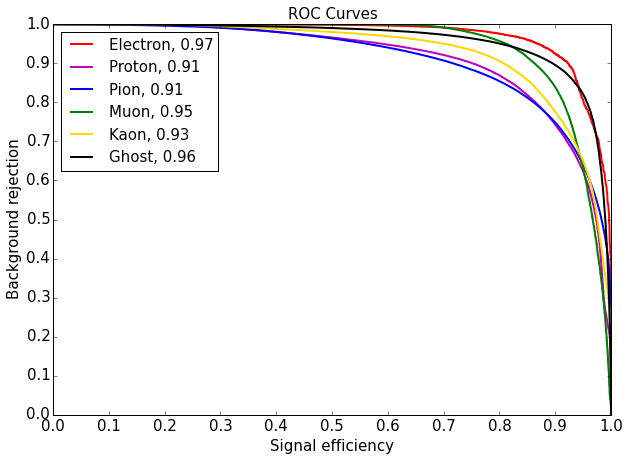

In [49]:
particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]
colors = ['k', 'r', 'g', 'b', 'gold', 'm']

plt.figure(figsize=(10,7))
plt.plot(tpr_electron, 1.-fpr_electron, label='Electron, %.2f' % roc_auc_electron, color='r', linewidth=2)
plt.plot(tpr_proton, 1.-fpr_proton, label='Proton, %.2f' % roc_auc_proton, color='m', linewidth=2)
plt.plot(tpr_pion, 1.-fpr_pion, label='Pion, %.2f' % roc_auc_pion, color='b', linewidth=2)
plt.plot(tpr_muon, 1.-fpr_muon, label='Muon, %.2f' % roc_auc_muon, color='g', linewidth=2)
plt.plot(tpr_kaon, 1.-fpr_kaon, label='Kaon, %.2f' % roc_auc_kaon, color='gold', linewidth=2)
plt.plot(tpr_ghost, 1.-fpr_ghost, label='Ghost, %.2f' % roc_auc_ghost, color='k', linewidth=2)
plt.title("ROC Curves", size=15)
plt.xlabel("Signal efficiency", size=15)
plt.ylabel("Background rejection", size=15)
plt.legend(loc='best',prop={'size':15})
plt.xticks(numpy.arange(0, 1.01, 0.1), size=15)
plt.yticks(numpy.arange(0, 1.01, 0.1), size=15)


plt.savefig(work_path + "/overall_roc_auc.png")

plt.show()

# Roc matrix

In [50]:
roc_auc_electron = roc_auc_score(labels_electron, proba_electron[:, 1])

probas_list = [proba_electron, proba_proton, proba_pion, proba_muon, proba_kaon, proba_ghost]
labels_list = [labels_electron, labels_proton, labels_pion, labels_muon, labels_kaon, labels_ghost]

roc_matrics = numpy.ones((6,6))

for i in range(0, 6):
    for j in range(0, 6):
        if i==j:
            continue
        sel = ((labels_list[i] != 0) + (labels_list[j] != 0)) * 1.
        roc_auc = roc_auc_score(labels_list[i], proba_overall[:, i]/proba_overall[:, j], sample_weight=sel)
        roc_matrics[i,j] = roc_auc

In [51]:
particles = ['Electron', 'Proton', 'Pion', 'Muon', 'Kaon', 'Ghost']

matrix = pandas.DataFrame(columns=['Particle'] + particles)
matrix['Particle'] = particles
matrix['Electron'] = roc_matrics[0, :]
matrix['Proton'] = roc_matrics[1, :]
matrix['Pion'] = roc_matrics[2, :]
matrix['Muon'] = roc_matrics[3, :]
matrix['Kaon'] = roc_matrics[4, :]
matrix['Ghost'] = roc_matrics[5, :]

matrix.to_csv(work_path + "/class_vs_class_roc_auc_matrix.csv")

matrix

,Particle,Electron,Proton,Pion,Muon,Kaon,Ghost
0,Electron,1.000000,0.983401,0.980666,0.994733,0.987262,0.951811
1,Proton,0.983401,1.000000,0.944491,0.978703,0.762775,0.974781
2,Pion,0.980666,0.944491,1.000000,0.948316,0.950826,0.961637
3,Muon,0.994733,0.978703,0.948316,1.000000,0.982660,0.982511
4,Kaon,0.987262,0.762775,0.950826,0.982660,1.000000,0.977580
5,Ghost,0.951811,0.974781,0.961637,0.982511,0.977580,1.000000


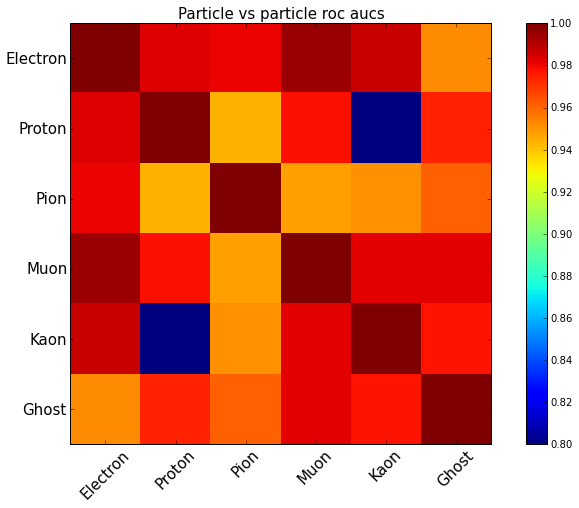

In [52]:


plt.figure(figsize=(10,7))
plt.imshow(roc_matrics, interpolation='nearest')
tick_marks = numpy.arange(len(particles))
plt.xticks(tick_marks, particles, rotation=45, size=15)
plt.yticks(tick_marks, particles, size=15)
plt.clim([0.8,1])
plt.colorbar()
plt.tight_layout()
plt.title('Particle vs particle roc aucs', size=15)


plt.savefig(work_path + "/class_vs_class_roc_auc_matrix.png")

plt.show()

# Relative ROC Matrix

In [54]:
matrix_baseline = pandas.read_csv(work_path + "/class_vs_class_roc_auc_matrix_baseline.csv")

In [55]:
rel_matrix = matrix
rel_matrix[particles] = matrix[particles].values / matrix_baseline[particles].values

In [56]:
rel_matrix.to_csv(work_path + "/class_vs_class_roc_auc_rel_matrix.csv")

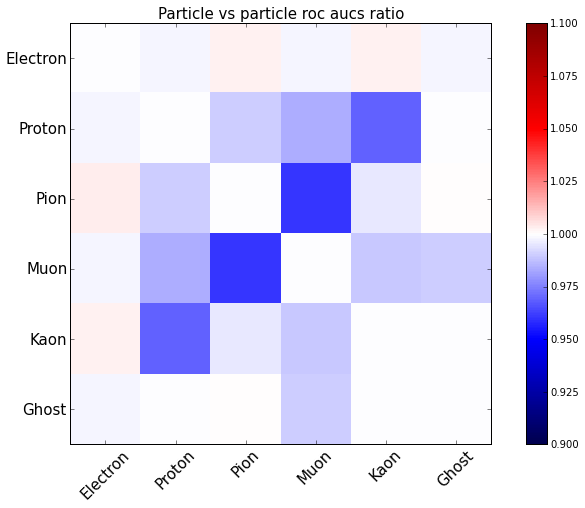

In [57]:
from matplotlib import cm
plt.figure(figsize=(10,7))
plt.imshow(rel_matrix[particles].values, interpolation='nearest', cmap=cm.seismic)
tick_marks = numpy.arange(len(particles))
plt.xticks(tick_marks, particles, rotation=45, size=15)
plt.yticks(tick_marks, particles, size=15)
plt.clim([0.9,1.1])
plt.colorbar()
plt.tight_layout()
plt.title('Particle vs particle roc aucs ratio', size=15)


plt.savefig(work_path + "/class_vs_class_roc_auc_rel_matrix.png")

plt.show()

In [58]:
rel_matrix

,Particle,Electron,Proton,Pion,Muon,Kaon,Ghost
0,Electron,1.000000,0.998017,1.002961,0.998336,1.002447,0.997755
1,Proton,0.998022,1.000000,0.989868,0.984142,0.969009,0.999250
2,Pion,1.003289,0.989867,1.000000,0.960248,0.995696,1.000588
3,Muon,0.998339,0.984143,0.960224,1.000000,0.989211,0.990319
4,Kaon,1.002414,0.969009,0.995696,0.989211,1.000000,0.999862
5,Ghost,0.997756,0.999250,1.000588,0.990319,0.999862,1.000000


# Flatness

In [59]:
flatness_baseline = pandas.read_csv(work_path + "/flatness_baseline.csv")

In [60]:
import os, sys
sys.path.append('../python')

from utils import compute_cvm

In [61]:
GeV = 1000
limits = {"TrackP": [100*GeV, 0],
          "TrackPt": [10*GeV, 0],
          "CombDLLe": [20, -20],
          "CombDLLmu": [20, -20],
          "CombDLLpi": [150, -150],
          "CombDLLk": [150, -150],
          "CombDLLp": [150, -150] }

In [62]:
track_p = data_eval.TrackP.values
sel_p = (track_p >= limits["TrackP"][1]) * (track_p < limits["TrackP"][0])

track_pt = data_eval.TrackPt.values
sel_pt = (track_pt >= limits["TrackPt"][1]) * (track_pt < limits["TrackPt"][0])

In [63]:
flatness = pandas.DataFrame(columns=['Particle', 'TrackP', 'TrackPt'])
flatness['Particle'] = particles

sel_electron_p = sel_p * (labels_electron == 1)
sel_electron_pt = sel_pt * (labels_electron == 1)
cvm_electron_p = compute_cvm(proba_electron[sel_electron_p, 1], track_p[sel_electron_p])
cvm_electron_pt = compute_cvm(proba_electron[sel_electron_pt, 1], track_pt[sel_electron_pt])

sel_proton_p = sel_p * (labels_proton == 1)
sel_proton_pt = sel_pt * (labels_proton == 1)
cvm_proton_p = compute_cvm(proba_proton[sel_proton_p, 1], track_p[sel_proton_p])
cvm_proton_pt = compute_cvm(proba_proton[sel_proton_pt, 1], track_pt[sel_proton_pt])

sel_pion_p = sel_p * (labels_pion == 1)
sel_pion_pt = sel_pt * (labels_pion == 1)
cvm_pion_p = compute_cvm(proba_pion[sel_pion_p, 1], track_p[sel_pion_p])
cvm_pion_pt = compute_cvm(proba_pion[sel_pion_pt, 1], track_pt[sel_pion_pt])

sel_muon_p = sel_p * (labels_muon == 1)
sel_muon_pt = sel_pt * (labels_muon == 1)
cvm_muon_p = compute_cvm(proba_muon[sel_muon_p, 1], track_p[sel_muon_p])
cvm_muon_pt = compute_cvm(proba_muon[sel_muon_pt, 1], track_pt[sel_muon_pt])

sel_kaon_p = sel_p * (labels_kaon == 1)
sel_kaon_pt = sel_pt * (labels_kaon == 1)
cvm_kaon_p = compute_cvm(proba_kaon[sel_kaon_p, 1], track_p[sel_kaon_p])
cvm_kaon_pt = compute_cvm(proba_kaon[sel_kaon_pt, 1], track_pt[sel_kaon_pt])

sel_ghost_p = sel_p * (labels_ghost == 1)
sel_ghost_pt = sel_pt * (labels_ghost == 1)
cvm_ghost_p = compute_cvm(proba_ghost[sel_ghost_p, 1], track_p[sel_ghost_p])
cvm_ghost_pt = compute_cvm(proba_ghost[sel_ghost_pt, 1], track_pt[sel_ghost_pt])

flatness['TrackP'] = [cvm_electron_p, cvm_proton_p, cvm_pion_p, cvm_muon_p, cvm_kaon_p, cvm_ghost_p]
flatness['TrackPt'] = [cvm_electron_pt, cvm_proton_pt, cvm_pion_pt, cvm_muon_pt, cvm_kaon_pt, cvm_ghost_pt]
flatness['P_Conf_level'] = flatness_baseline['P_Conf_level'].values
flatness['Pt_Conf_level'] = flatness_baseline['Pt_Conf_level'].values


flatness.to_csv(work_path + "/flatness.csv")

In [64]:
flatness

,Particle,TrackP,TrackPt,P_Conf_level,Pt_Conf_level
0,Electron,0.017368,0.036358,0.001014,0.001004
1,Proton,0.032674,0.046619,0.000886,0.000888
2,Pion,0.031394,0.019003,0.000853,0.000851
3,Muon,0.034479,0.053813,0.000905,0.000906
4,Kaon,0.033887,0.036099,0.000872,0.000880
5,Ghost,0.006376,0.018189,0.000871,0.000870


In [65]:
rel_flatness = flatness
rel_flatness[['TrackP', 'TrackPt']] = flatness[['TrackP', 'TrackPt']].values / flatness_baseline[['TrackP', 'TrackPt']]

In [66]:
rel_flatness[['Particle', 'TrackP', 'TrackPt']].to_csv(work_path + "/rel_flatness.csv")
rel_flatness[['Particle', 'TrackP', 'TrackPt']]

,Particle,TrackP,TrackPt
0,Electron,2.653220,2.193024
1,Proton,0.943470,1.045943
2,Pion,1.901285,1.384156
3,Muon,1.691168,1.196079
4,Kaon,0.786717,0.984763
5,Ghost,0.967470,1.282083


### CvM test value for TrackP flatness

In [42]:
def get_flatness_threshold(N, q, track_p, sel_p):
    cvm_pdf = []
    for step in range(N):
        proba_rand = numpy.random.random(len(track_p[sel_p]))
        cvm_pdf.append(compute_cvm(proba_rand, track_p[sel_p]))
    cvm_pdf = numpy.array(cvm_pdf)
    threshold = numpy.percentile(cvm_pdf, q)

    return threshold

In [44]:
threshold_electron_p = get_flatness_threshold(1000, 95, track_p, sel_electron_p)
threshold_proton_p = get_flatness_threshold(1000, 95, track_p, sel_proton_p)
threshold_pion_p = get_flatness_threshold(1000, 95, track_p, sel_pion_p)
threshold_muon_p = get_flatness_threshold(1000, 95, track_p, sel_muon_p)
threshold_kaon_p = get_flatness_threshold(1000, 95, track_p, sel_kaon_p)
threshold_ghost_p = get_flatness_threshold(1000, 95, track_p, sel_ghost_p)

### CvM test value for TrackPt flatness

In [45]:
threshold_electron_pt = get_flatness_threshold(1000, 95, track_pt, sel_electron_pt)
threshold_proton_pt = get_flatness_threshold(1000, 95, track_pt, sel_proton_pt)
threshold_pion_pt = get_flatness_threshold(1000, 95, track_pt, sel_pion_pt)
threshold_muon_pt = get_flatness_threshold(1000, 95, track_pt, sel_muon_pt)
threshold_kaon_pt = get_flatness_threshold(1000, 95, track_pt, sel_kaon_pt)
threshold_ghost_pt = get_flatness_threshold(1000, 95, track_p, sel_ghost_pt)

In [48]:
flatness['P_Conf_level'] = [threshold_electron_p, 
                            threshold_proton_p, 
                            threshold_pion_p, 
                            threshold_muon_p, 
                            threshold_kaon_p, 
                            threshold_ghost_p]
flatness['Pt_Conf_level'] = [threshold_electron_pt, 
                            threshold_proton_pt, 
                            threshold_pion_pt, 
                            threshold_muon_pt, 
                            threshold_kaon_pt, 
                            threshold_ghost_pt]

flatness.to_csv(work_path_electron + "/flatness.csv")
flatness.to_csv(work_path_proton + "/flatness.csv")
flatness.to_csv(work_path_pion + "/flatness.csv")
flatness.to_csv(work_path_muon + "/flatness.csv")
flatness.to_csv(work_path_kaon + "/flatness.csv")
flatness.to_csv(work_path_ghost + "/flatness.csv")

In [63]:
#flatness

# Efficiency curves

In [67]:
from rep.utils import get_efficiencies
from rep.plotting import ErrorPlot

def flatness_p_figure(proba, track_p, sel_p, track, particle, work_path):

    thresholds = numpy.percentile(proba[sel_p, 1], 100 - numpy.array([5, 20, 40, 60, 80]))

    eff = get_efficiencies(proba[sel_p, 1], 
                           track_p[sel_p], 
                           bins_number=30, 
                           errors=True, 
                           ignored_sideband=0, 
                           thresholds=thresholds)
    
    for i in thresholds:
        eff[i] = (eff[i][0], 100. * eff[i][1], 100. * eff[i][2], eff[i][3])
    
    plot_fig = ErrorPlot(eff)
    plot_fig.ylim = (0, 100)

    plot_fig.plot(new_plot=True, figsize=(10,7))
    plt.legend(['Eff = 5 %', 'Eff = 20 %', 'Eff = 40 %', 'Eff = 60 %', 'Eff = 80 %'], loc='best',prop={'size':15})
    plt.xlabel(track + ' ' + particle + ' Momentum / MeV/c', size=15)
    plt.xticks(size=15)
    plt.ylabel('Efficiency / %', size=15)
    plt.yticks(size=15)
    plt.title('Flatness_SignalMVAEffVTrackP_' + track + ' ' + particle, size=15)
    plt.savefig(work_path + "/" + 'Flatness_SignalMVAEffVTrackP_' + track + '_' + particle + ".png")

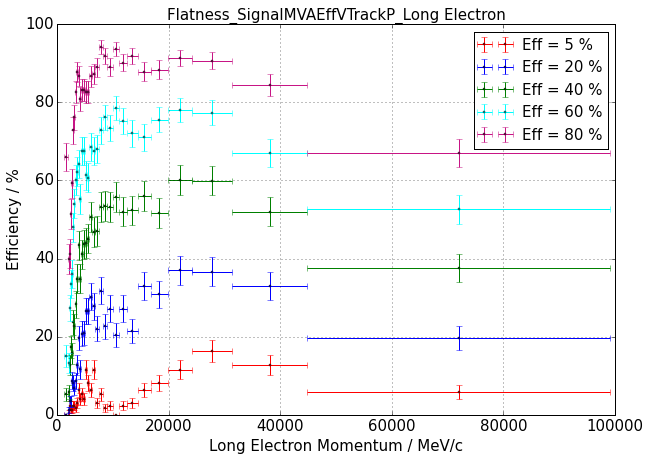

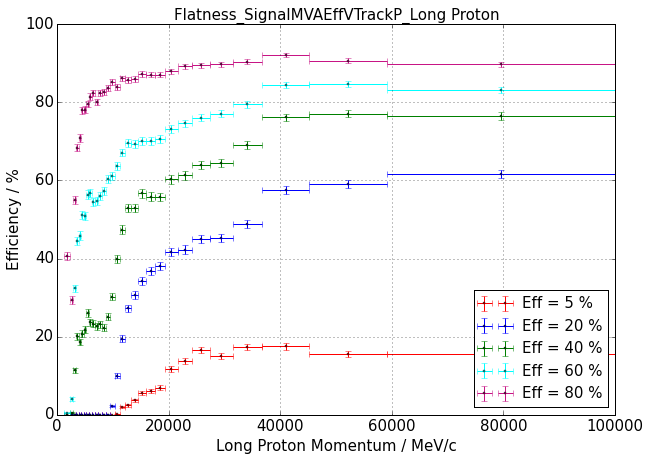

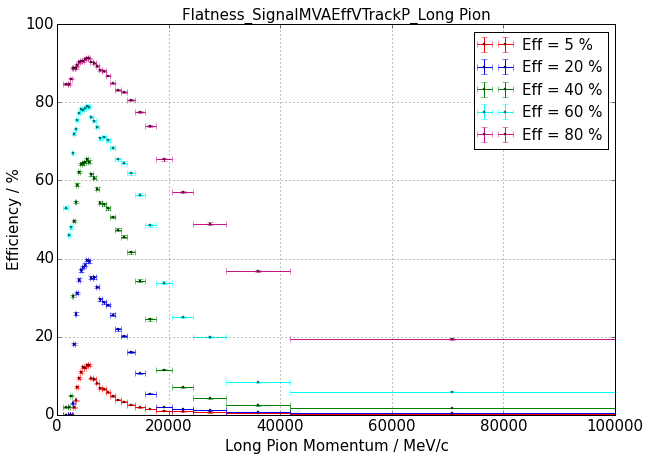

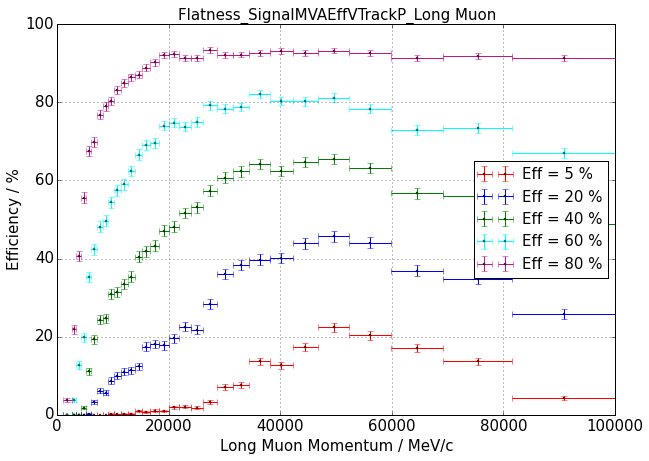

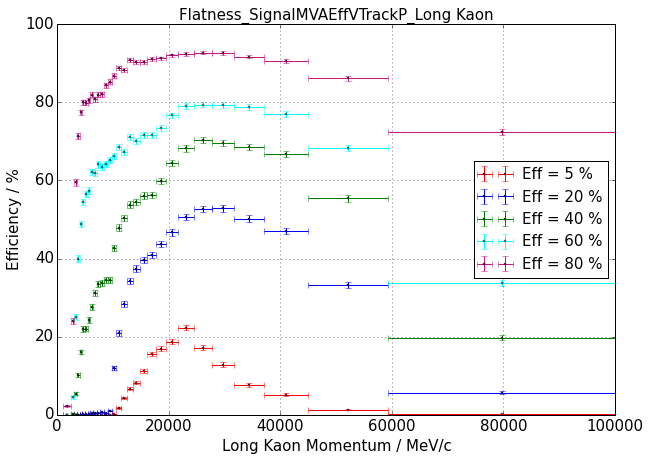

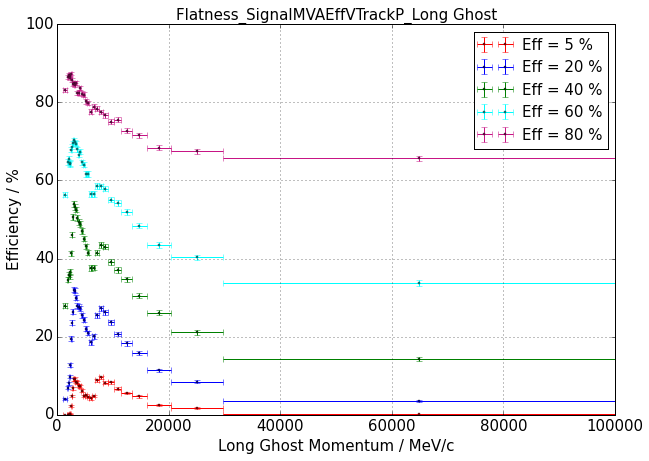

In [68]:
flatness_p_figure(proba_electron, track_p, sel_electron_p, 'Long', 'Electron', work_path)
flatness_p_figure(proba_proton, track_p, sel_proton_p, 'Long', 'Proton', work_path)
flatness_p_figure(proba_pion, track_p, sel_pion_p, 'Long', 'Pion', work_path)
flatness_p_figure(proba_muon, track_p, sel_muon_p, 'Long', 'Muon', work_path)
flatness_p_figure(proba_kaon, track_p, sel_kaon_p, 'Long', 'Kaon', work_path)
flatness_p_figure(proba_ghost, track_p, sel_ghost_p, 'Long', 'Ghost', work_path)

In [69]:
from rep.utils import get_efficiencies
from rep.plotting import ErrorPlot

def flatness_pt_figure(proba, track_pt, sel_pt, track, particle, work_path):

    thresholds = numpy.percentile(proba[sel_pt, 1], 100 - numpy.array([5, 20, 40, 60, 80]))

    eff = get_efficiencies(proba[sel_pt, 1], 
                           track_pt[sel_pt], 
                           bins_number=30, 
                           errors=True, 
                           ignored_sideband=0, 
                           thresholds=thresholds)
    for i in thresholds:
        eff[i] = (eff[i][0], 100. * eff[i][1], 100. * eff[i][2], eff[i][3])
    
    plot_fig = ErrorPlot(eff)
    plot_fig.ylim = (0, 100)

    plot_fig.plot(new_plot=True, figsize=(10,7))
    plt.legend(['Eff = 5 %', 'Eff = 20 %', 'Eff = 40 %', 'Eff = 60 %', 'Eff = 80 %'], loc='best',prop={'size':15})
    plt.xlabel(track + ' ' + particle + ' Transverse Momentum / MeV/c', size=15)
    plt.xticks(size=15)
    plt.ylabel('Efficiency / %', size=15)
    plt.yticks(size=15)
    plt.title('Flatness_SignalMVAEffVTrackPt_' + track + ' ' + particle, size=15)
    plt.savefig(work_path + "/" + 'Flatness_SignalMVAEffVTrackPt_' + track + '_' + particle + ".png")

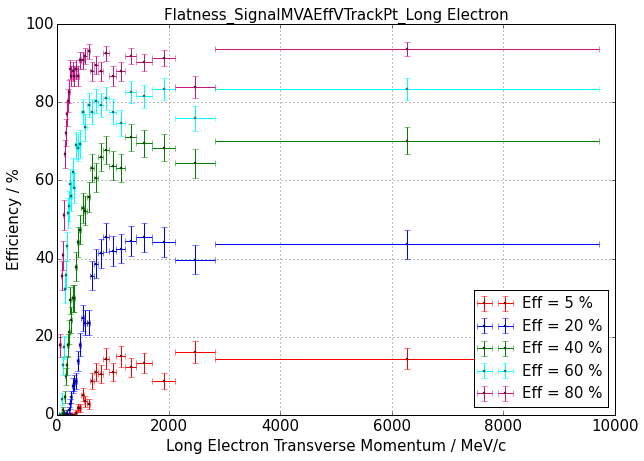

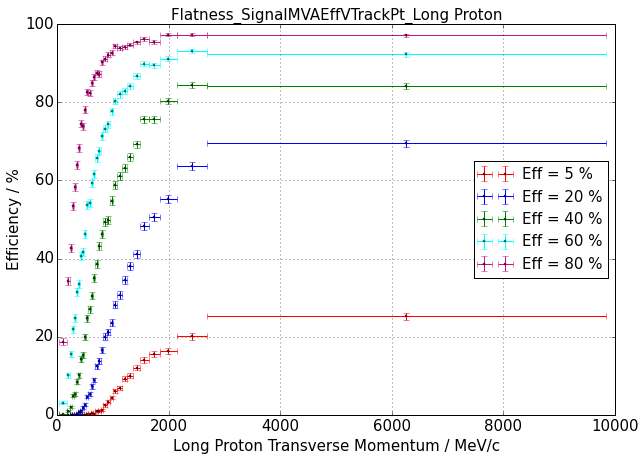

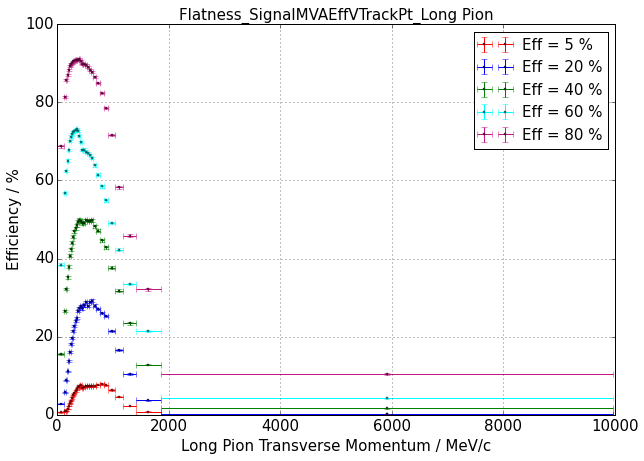

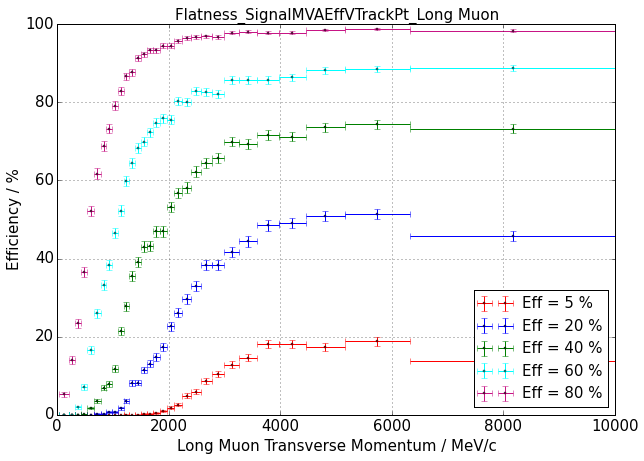

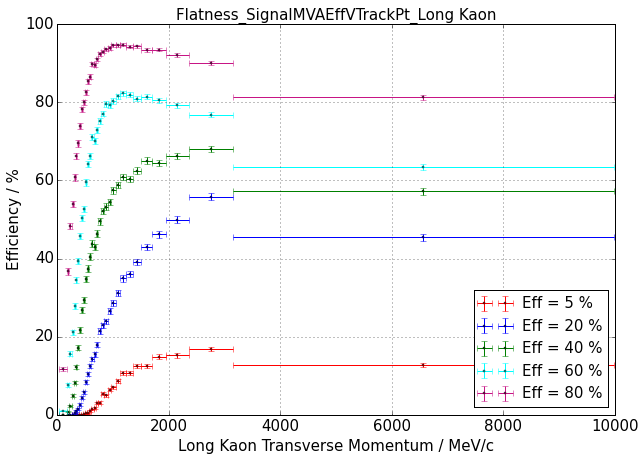

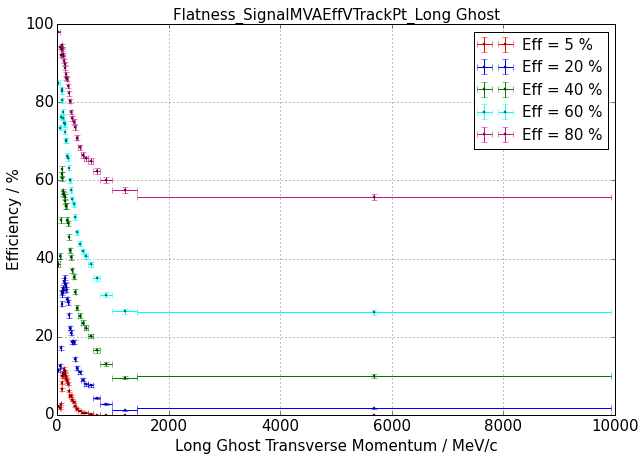

In [70]:
flatness_pt_figure(proba_electron, track_pt, sel_electron_pt, 'Long', 'Electron', work_path)
flatness_pt_figure(proba_proton, track_pt, sel_proton_pt, 'Long', 'Proton', work_path)
flatness_pt_figure(proba_pion, track_pt, sel_pion_pt, 'Long', 'Pion', work_path)
flatness_pt_figure(proba_muon, track_pt, sel_muon_pt, 'Long', 'Muon', work_path)
flatness_pt_figure(proba_kaon, track_pt, sel_kaon_pt, 'Long', 'Kaon', work_path)
flatness_pt_figure(proba_ghost, track_pt, sel_ghost_pt, 'Long', 'Ghost', work_path)